# Lecture : Shallow Graph Feature Learning

## Lab 01 : DeepWalk - Exercise

### Xavier Bresson, Guoji Fu   

Perozzi, Al-Rfou, Skiena, DeepWalk: Online learning of social representations, 2014  
https://arxiv.org/pdf/1403.6652.pdf

Notebook goals :<br>
• Design a random walk extractor <br>
• Implement the deepwalk technique <br>
• Compare visually the deepwalk embedding with networkx visualization <br>


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/07_Shallow_Learning'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install rdkit==2023.09.6 # Install RDKit
    !pip install dgl==1.0.0 # Install DGL


In [1]:
# Libraries
import pickle
import sys; sys.path.insert(0, 'lib/')
from lib.utils import Molecule
from rdkit import Chem
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import random
from lib.utils import compute_ncut


## Load dataset and select one molecule

Loading data
tensor([0, 5, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 4, 0, 0, 0, 2]) torch.Size([23])
tensor([ 0,  0,  1,  2,  3,  4,  0,  0,  5,  6,  7,  8,  9, 10,  1, 11,  1, 12,
         0, 13, 14, 15,  2]) torch.Size([23])
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0

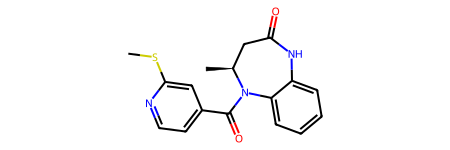

In [4]:
print('Loading data')
data_folder_pytorch = 'datasets/ZINC_pytorch/'
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    dataset=pickle.load(f)

# Select one molecule
idx = 12
mol = dataset[idx]
print(mol.atom_type, mol.atom_type.shape)
print(mol.atom_type_pe, mol.atom_type_pe.shape)
print(mol.bond_type, mol.bond_type.shape)
print(mol.bag_of_atoms, mol.bag_of_atoms.shape)
print(mol.logP_SA_cycle_normalized, mol.logP_SA_cycle_normalized.shape)
print(mol.smile)
Chem.MolFromSmiles(mol.smile)


In [5]:
# Let's examine the bond_type matrix structure
print("Bond type matrix shape:", mol.bond_type.shape)
print("Number of atoms in this molecule:", mol.num_atom)
print("\nUnique bond types in this molecule:")
print("Bond types:", torch.unique(mol.bond_type))
print("\nFirst few rows of bond_type matrix:")
print(mol.bond_type[:5, :5])

# Count different bond types
print(f"\nBond type counts:")
unique_bonds, counts = torch.unique(mol.bond_type, return_counts=True)
for bond_val, count in zip(unique_bonds, counts):
    if bond_val == 0:
        print(f"  No bond (0): {count} pairs")
    else:
        print(f"  Bond type {bond_val}: {count} pairs")

# Check if matrix is symmetric (should be for undirected molecular graphs)
is_symmetric = torch.equal(mol.bond_type, mol.bond_type.T)
print(f"\nIs bond matrix symmetric? {is_symmetric}")

# Create adjacency matrix (any bond type > 0 means connected)
adjacency = (mol.bond_type > 0).float()
print(f"\nNumber of actual bonds: {adjacency.sum().item() // 2}")  # divide by 2 since symmetric

Bond type matrix shape: torch.Size([23, 23])
Number of atoms in this molecule: 23

Unique bond types in this molecule:
Bond types: tensor([0, 1, 2])

First few rows of bond_type matrix:
tensor([[0, 1, 0, 0, 0],
        [1, 0, 1, 0, 0],
        [0, 1, 0, 2, 0],
        [0, 0, 2, 0, 1],
        [0, 0, 0, 1, 0]])

Bond type counts:
  No bond (0): 479 pairs
  Bond type 1: 34 pairs
  Bond type 2: 16 pairs

Is bond matrix symmetric? True

Number of actual bonds: 25.0


#### Understanding the Bond Type Matrix

The `mol.bond_type` has shape (23, 23) because:

1. **23 × 23 = Number of Atoms**: This molecule contains 23 atoms
2. **Matrix Representation**: Each element `bond_type[i,j]` represents the bond between atom `i` and atom `j`
3. **Bond Type Encoding**:
   - `0`: No bond between atoms
   - `1`: Single bond
   - `2`: Double bond  
   - `3`: Triple bond
   - `4`: Aromatic bond
   - etc.

4. **Symmetry**: The matrix is symmetric because if atom `i` is bonded to atom `j`, then atom `j` is also bonded to atom `i`
5. **Sparsity**: Most elements are 0 since each atom is only bonded to a few neighboring atoms

This representation allows us to capture both the **connectivity** (which atoms are connected) and the **bond types** (what kind of chemical bonds exist) in a single matrix.

## Exercise 1 : Design a random walk extractor

### Question 1.1 : Implement a class that generates a random walk path.

Hints:
- Sample the next node from the RW probability `prob_j = sample(RW[i,:]`.
- Use Bernoulli sampling with function `torch.distributions.Categorical(prob).sample()`.


In [6]:
class sample_RW_path:

    def __init__(self, num_steps, RW):
        self.num_steps = num_steps # number of steps
        self.RW = RW # random walk matrix
        self.num_nodes = RW.size(0) # number of nodes

    def sample_walk(self, idx_start):
        idx = torch.tensor(idx_start).long() # starting index of the walk
        RWpath = [idx] # random walk path
        for _ in range(self.num_steps-1):
            ########################################
            # YOUR CODE START
            # sample the next node from the RW probability prob_j = sample(RW[i,:]
            # use Bernoulli sampling with torch.distributions.Categorical(prob).sample()
            ########################################

            # Get the row corresponding to the current node
            # answer
            # idx = torch.distributions.Categorical(self.RW[idx, :]).sample()
            idx = torch.distributions.Categorical(self.RW[idx]).sample()

            ########################################
            # YOUR CODE END
            ########################################

            RWpath.append(idx) # append sampled node to the path
        RWpath = torch.stack(RWpath).flatten() # path format = torch.tensor([idx_1, idx_2, ..., idx_num_steps])
        return RWpath



### Question 1.2 : Use the previously defined function to sample a random walk path.

Hints:
- Step 1: Compute the RW operator with $RW = D^{-1}A$.
- Step 2: Choose the number of RW steps.
- Step 3: Use `sample_RW_path()` to instantiate a RW class.
- Step 4: Apply `sample_walk()` to extract a RW path.
  

In [7]:
A = (mol.bond_type>0).float() # Adjacency matrix
D = A.sum(dim=0) # Degree vector

########################################
# YOUR CODE START
########################################

# Step 1: # Compute the RW operator
# Compute the inverse degree matrix
# answer
# Dinv = (D**(-1))).diag()
# assume no isolated nodes
Dinv = D.pow(-1).diag()

# Compute RW matrix
RW = Dinv @ A

# Step 2: choose the number of RW steps
num_RW_steps = 5

# Step 3: instantiate RW class
generator = sample_RW_path(num_RW_steps, RW)

# Step 4: sample RW path starting with index=7
walk = generator.sample_walk(7)

########################################
# YOUR CODE END
########################################

print('RW:',walk)



RW: tensor([ 7, 18, 17, 15, 16])


### Visualise the sampled RW path

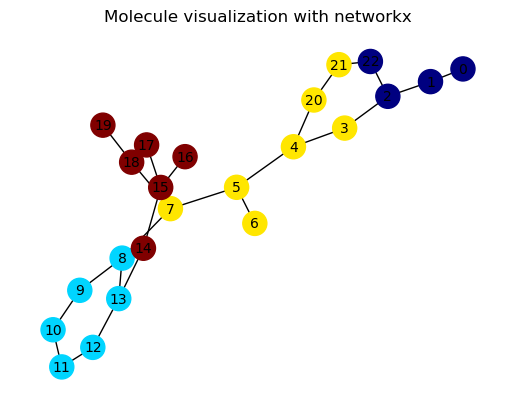

In [8]:
# Check visually RW path correctness
fig = plt.figure()
ax = fig.add_subplot(111)
A_nx = nx.from_numpy_array(A.numpy())
C = compute_ncut(A.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Molecule visualization with networkx')
plt.show()

## Exercise 2 : Implement the DeepWalk paper

### Question 2.1 : Implement a DeepWalk network class and apply it to molecular graphs.

Instructions:
- Step 1: Extract the embedding $h_i$ for node i. You can use the `.unsqueeze()` method.
- Step 2: Extract the embeddings $h_j$ for nodes j in the RW. You may use the `.transpose()` method.
- Step 3: Extract the embeddings $h_k$ for nodes k not in the RW. 


In [11]:
class deepwalk_net(nn.Module):

    def __init__(self, num_nodes, hidden_dim, num_negative):
        super(deepwalk_net, self).__init__()
        print(num_nodes, hidden_dim)
        self.num_nodes = num_nodes
        self.num_negative = num_negative
        # shape of node_embedding = (num_nodes, hidden_dim)
        self.node_embedding = nn.Embedding(num_nodes, hidden_dim)

    def forward(self, walk):
        walk_list = walk.tolist() # list nodes in RW
        node_list = list(range(self.num_nodes)) # list all nodes
        list_negative = torch.tensor(list(set(node_list) - set(walk_list))) # all possible negative samples
        #list_negative = list_negative[torch.randperm(list_negative.size(0))] # ???
        loss = []
        for i in walk: # loop over all nodes in RW
                       # node i that must predict all other nodes j in RW

            ########################################
            # YOUR CODE START
            ########################################

            # positive samples
            # Step1: extract embedding hi of node i
            # shape: (1, hidden_dim)
            hi = self.node_embedding(i).unsqueeze(0) # embed node i
            # hi = self.node_embedding(i) is not correct  # shape: (hidden_dim,)

            # Step 2: extract embedding hj of nodes j in RW
            j = torch.tensor(list(set(walk_list) - set([i.detach().item()]))) # all other nodes j in RW
            # hj.size()=(num_RW_steps-1,hidden_dim)
            hj = self.node_embedding(j).transpose(1, 0) # embed nodes j

            # negative samples : select randomly "num_negative" nodes which are not in the RW path
            list_negative = list_negative[torch.randperm(list_negative.size(0))][:self.num_negative] # select randomly "num_negative" negative samples

            # Step 3: extract embedding hk of nodes k not in RW
            # hk.size()=(num_negative,hidden_dim)
            hk = self.node_embedding(list_negative).transpose(1, 0) # embed negative nodes k

            ########################################
            # YOUR CODE END
            ########################################

            # compute loss
            loss_i = - ( torch.log(torch.sigmoid(torch.mm(hi,hj))).sum() - 0.25*torch.log(torch.sigmoid(torch.mm(hi,hk))).sum() )
            loss.append(loss_i)
        loss = torch.stack(loss).mean()
        return loss




#### Understanding the Transpose Operations in DeepWalk



Let's break down why we need `.transpose()` and `.unsqueeze()` operations:

##### The Problem: Matrix Multiplication Dimensions

In DeepWalk, we need to compute **similarity scores** between embeddings using dot products:
- `torch.mm(hi, hj)` for positive samples  
- `torch.mm(hi, hk)` for negative samples

##### Dimension Requirements for `torch.mm(A, B)`:
- `A.shape = (m, n)` and `B.shape = (n, p)` → Result: `(m, p)`
- The **inner dimensions must match**!

##### Let's trace through the dimensions:

1. **`hi` (target node embedding)**:
   - `self.node_embedding(i)` → shape: `(hidden_dim,)` 
   - `hi = self.node_embedding(i).unsqueeze(0)` → shape: `(1, hidden_dim)`
   - **Purpose**: Convert from 1D vector to 2D matrix for matrix multiplication

2. **`hj` (positive context embeddings)**:
   - `self.node_embedding(j)` → shape: `(num_positive_nodes, hidden_dim)`
   - `hj = self.node_embedding(j).transpose(1, 0)` → shape: `(hidden_dim, num_positive_nodes)`
   - **Purpose**: Transpose so we can multiply `(1, hidden_dim) × (hidden_dim, num_positive_nodes)`

3. **`hk` (negative context embeddings)**:
   - `self.node_embedding(list_negative)` → shape: `(num_negative, hidden_dim)`
   - `hk = self.node_embedding(list_negative).transpose(1, 0)` → shape: `(hidden_dim, num_negative)`
   - **Purpose**: Same as above - enable matrix multiplication

##### Final Matrix Multiplications:
- `torch.mm(hi, hj)` = `(1, hidden_dim) × (hidden_dim, num_positive_nodes)` = `(1, num_positive_nodes)`
- `torch.mm(hi, hk)` = `(1, hidden_dim) × (hidden_dim, num_negative)` = `(1, num_negative)`

This gives us **similarity scores** between the target node and all positive/negative context nodes!

In [9]:
# Let's demonstrate why transpose is needed with a concrete example
print("=== DeepWalk Transpose Example ===")

# Simulate the embedding layer
hidden_dim = 4  # smaller for demo
num_nodes = 10
embedding_layer = nn.Embedding(num_nodes, hidden_dim)

# Simulate a random walk: [2, 5, 8, 3]
walk_list = [2, 5, 8, 3]
i = 2  # current target node
j_nodes = [5, 8, 3]  # positive context nodes (others in walk)
k_nodes = [0, 1]  # negative nodes (not in walk)

print(f"Target node i = {i}")
print(f"Positive context nodes j = {j_nodes}")
print(f"Negative nodes k = {k_nodes}")
print()

# Step 1: Extract hi (target embedding)
hi_raw = embedding_layer(torch.tensor(i))
hi = hi_raw.unsqueeze(0)
print(f"hi_raw shape: {hi_raw.shape}")  # (hidden_dim,)
print(f"hi shape after unsqueeze: {hi.shape}")  # (1, hidden_dim)
print()

# Step 2: Extract hj (positive embeddings)  
hj_raw = embedding_layer(torch.tensor(j_nodes))
hj = hj_raw.transpose(1, 0)
print(f"hj_raw shape: {hj_raw.shape}")  # (num_positive, hidden_dim)
print(f"hj shape after transpose: {hj.shape}")  # (hidden_dim, num_positive)
print()

# Step 3: Extract hk (negative embeddings)
hk_raw = embedding_layer(torch.tensor(k_nodes))
hk = hk_raw.transpose(1, 0)
print(f"hk_raw shape: {hk_raw.shape}")  # (num_negative, hidden_dim)
print(f"hk shape after transpose: {hk.shape}")  # (hidden_dim, num_negative)
print()

# Step 4: Matrix multiplications
positive_scores = torch.mm(hi, hj)
negative_scores = torch.mm(hi, hk)

print(f"positive_scores shape: {positive_scores.shape}")  # (1, num_positive)
print(f"negative_scores shape: {negative_scores.shape}")  # (1, num_negative)
print()
print(f"positive_scores: {positive_scores}")
print(f"negative_scores: {negative_scores}")

print("\n=== Without transpose (would fail!) ===")
try:
    # This would fail because dimensions don't match:
    # (1, hidden_dim) × (num_positive, hidden_dim) - inner dimensions 4 ≠ 3
    wrong_mult = torch.mm(hi, hj_raw)
except RuntimeError as e:
    print(f"Error: {e}")
    print("That's why we need transpose!")

=== DeepWalk Transpose Example ===
Target node i = 2
Positive context nodes j = [5, 8, 3]
Negative nodes k = [0, 1]

hi_raw shape: torch.Size([4])
hi shape after unsqueeze: torch.Size([1, 4])

hj_raw shape: torch.Size([3, 4])
hj shape after transpose: torch.Size([4, 3])

hk_raw shape: torch.Size([2, 4])
hk shape after transpose: torch.Size([4, 2])

positive_scores shape: torch.Size([1, 3])
negative_scores shape: torch.Size([1, 2])

positive_scores: tensor([[ 1.3815, -2.8089,  0.8910]], grad_fn=<MmBackward0>)
negative_scores: tensor([[0.4499, 1.3541]], grad_fn=<MmBackward0>)

=== Without transpose (would fail!) ===
Error: mat1 and mat2 shapes cannot be multiplied (1x4 and 3x4)
That's why we need transpose!


### Question 2.2 : Instantiate a DeepWalk network

Instructions:
- Select the number of negative samples and use the `deepwalk()` function to instantiate the network.
- Evaluate and compare the performance of DeepWalk networks using different numbers of negative samples.


In [12]:
num_nodes = A.size(0)

########################################
# YOUR CODE START
########################################

# select num_negative = num_RW_steps/4
net = deepwalk_net(num_nodes, hidden_dim=2, num_negative=num_RW_steps//4)

########################################
# YOUR CODE END
########################################

print(net)


23 2
deepwalk_net(
  (node_embedding): Embedding(23, 2)
)


### Train the deepwalk network

In [13]:
# Train the network
optimizer = torch.optim.Adam( net.parameters() , lr=0.001 )
for iter in range(300):
    loss_epoch = 0.0
    for idx in torch.randperm(num_nodes).tolist(): # shuffle ordering of nodes
        walk = generator.sample_walk(idx)
        loss = net(walk)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach()
        with torch.no_grad():
            # centering the embedding coordinates
            # helps optimization by reducing one degree of freedom
            net.node_embedding.weight.sub_(net.node_embedding.weight.mean(dim=0))
    # plot the loss value
    if not iter%10:
        print(iter,loss_epoch/num_nodes)



0 tensor(1.9726)
10 tensor(2.1312)
10 tensor(2.1312)
20 tensor(2.0417)
20 tensor(2.0417)
30 tensor(1.4681)
30 tensor(1.4681)
40 tensor(1.9483)
40 tensor(1.9483)
50 tensor(1.7348)
50 tensor(1.7348)
60 tensor(1.4285)
60 tensor(1.4285)
70 tensor(1.3550)
70 tensor(1.3550)
80 tensor(1.4275)
80 tensor(1.4275)
90 tensor(1.0881)
90 tensor(1.0881)
100 tensor(1.1969)
100 tensor(1.1969)
110 tensor(1.2813)
110 tensor(1.2813)
120 tensor(1.2213)
120 tensor(1.2213)
130 tensor(1.1171)
130 tensor(1.1171)
140 tensor(0.7760)
140 tensor(0.7760)
150 tensor(1.0662)
150 tensor(1.0662)
160 tensor(0.8499)
160 tensor(0.8499)
170 tensor(0.7576)
170 tensor(0.7576)
180 tensor(0.5181)
180 tensor(0.5181)
190 tensor(0.4636)
190 tensor(0.4636)
200 tensor(0.8291)
200 tensor(0.8291)
210 tensor(0.4042)
210 tensor(0.4042)
220 tensor(0.1922)
220 tensor(0.1922)
230 tensor(0.3485)
230 tensor(0.3485)
240 tensor(-0.0683)
240 tensor(-0.0683)
250 tensor(0.3185)
250 tensor(0.3185)
260 tensor(0.1597)
260 tensor(0.1597)
270 tensor(

### Visualize the node embeddings in 2D

tensor([[-2.2145,  2.0005],
        [-2.8953,  0.7875],
        [-2.8669,  3.2204],
        [-1.8914,  1.2765],
        [-1.7639,  1.7116],
        [-1.1170,  0.1349],
        [-1.1818, -0.0682],
        [-0.2856, -1.0674],
        [ 0.4492, -0.7099],
        [ 0.4726, -2.0769],
        [ 1.7414, -1.8871],
        [ 2.0865, -2.4887],
        [ 1.1150, -2.0049],
        [ 0.4561, -2.0836],
        [ 1.1740, -0.7578],
        [ 1.5054, -0.1799],
        [ 1.9397,  1.2646],
        [ 2.0189, -0.5245],
        [ 1.3925, -1.6247],
        [ 1.4872, -0.8691],
        [-0.1784,  2.3184],
        [-0.4246,  1.6682],
        [-1.0189,  1.9601]]) torch.Size([23, 2])


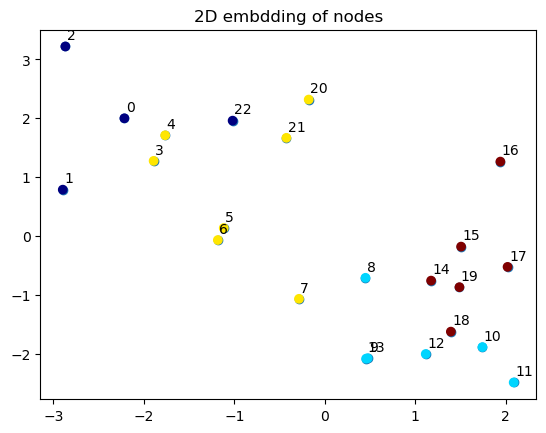

In [14]:
# Visualize the 2D coordinates of the node embeddings
x = net.node_embedding.weight.detach()
print(x,x.size())

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x[:,0], x[:,1])
idx = list(range(num_nodes))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embdding of nodes')
plt.show()

### Question 2.3 : Compare visually the deepwalk embedding with the networkx visualization


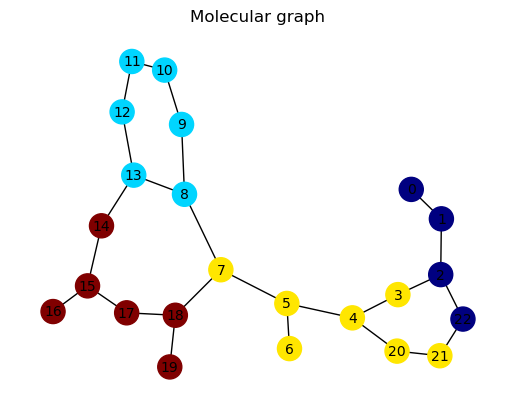

In [15]:
# Compare with graph edges
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Molecular graph')
plt.show()
